In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from DiRect import *

/home/sangwoong/Projects/env/ml_research/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Trivial 1-D Example

0.0277777777778 [ 0.5]
0.00308641975309 [ 0.5]
0.000342935528121 [ 0.5]
3.8103947569e-05 [ 0.5]


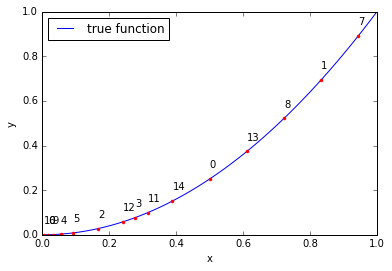

In [2]:
func_1d = lambda x: (x**2)[0] # f: vector to scalar
b = np.array([[0,1]])
direct = DiRect(func_1d, b, max_iter=4)
direct.run()
plt.figure()
x = np.linspace(b[0,0], b[0,1], 100).reshape((1,-1))
y = func_1d(x)
plt.plot(x.flatten(),y, label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
i = 0
for hist in direct.l_hist:
    plt.plot(hist[0], hist[1], 'r.')
    plt.text(hist[0], hist[1]+0.05, i)
    i += 1

# Non-Trivial 1D

[-0.79891441] [ 0.83333333]
[-1.27185773] [ 0.94444444]
[-1.43052245] [ 0.94444444]


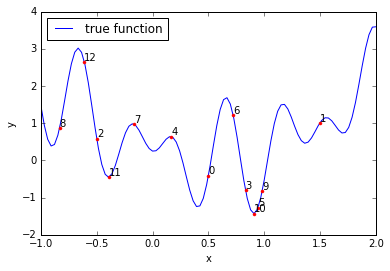

In [3]:
def func_1d(x):
    return ((x-0.5)**2 + np.sin(x*2.1)* np.sin(x*12)*1.7)
b = np.array([[-1,2]])
direct = DiRect(func_1d, b, max_feval=12)
direct.run()
plt.figure()
x = np.linspace(b[0,0], b[0,1], 100)
y = np.array([func_1d(xx) for xx in x])
true_opt = np.min(y)
plt.plot(x.flatten(),y, label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
i = 0
for hist in direct.l_hist:
    plt.plot(hist[0], hist[1], 'r.')
    plt.text(hist[0], hist[1]+0.05, i)
    i += 1
    

## Performance versus random search

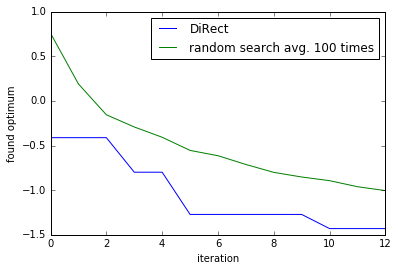

In [4]:
h = np.array([yy for xx, yy in direct.l_hist])
search = np.minimum.accumulate(h)

nRand = 100
rand_search = np.zeros((search.shape[0],))
for ii in xrange(nRand):
    np.random.shuffle(y)
    rand_search += np.minimum.accumulate(y[:search.shape[0]])
rand_search /= float(nRand)
plt.plot(search, label='DiRect')
plt.plot(rand_search, label='random search avg. 100 times')
plt.legend(loc='best')
plt.xlabel('iteration')
plt.ylabel('found optimum')

## Scikit-Learn Hyperparameter Search Demo

In [5]:
class DiRectHyperOpt(object):
    def __init__(self, model, train_x, train_y):
        self.model = model
        self.train_x = train_x
        self.train_y = train_y

    def f(self, vec):
        evaluator = GridSearchCV(self.model, cv=3, 
                                 param_grid={'alpha':[10 ** vec[0]], 
                                             'gamma':[10 ** vec[1]]})
        evaluator.fit(self.train_x, self.train_y)
        self.temp_evaluator = evaluator
        print vec, evaluator.best_score_
        return evaluator.best_score_

    def run_opt(self, bounds):
        direct = DiRect(self.f, bounds, max_feval=40, minimize=False)
        opt_val, x_at_opt, l_hist = direct.run()
        self.f(x_at_opt)
        print 'done'
        print opt_val, x_at_opt
        return self.temp_evaluator

# d = DiRectHyperOpt(normalize_kr, train_x, train_y)
# opt_model = d.run_opt(np.array([[-5,0],[-6,0]]))


In [6]:
from sklearn.datasets import load_boston
boston = load_boston()
train_x = boston.data
train_y = boston.target

In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.grid_search import GridSearchCV
model = KernelRidge(kernel='rbf')
direct = DiRectHyperOpt(model, train_x, train_y)
direct.run_opt(np.array([[-6, 0],[-6, 0]]))

[-3. -3.] -2.14636987357
[-1. -3.] -2.09306875005
2.09306875005 [-1. -3.]
[-5. -3.] -2.93102260582
[-3. -1.] -8.325448205
[-3. -5.] -3.39949057395
[-2.33333333 -3.        ] -2.14789200454
[-3.66666667 -3.        ] -2.22114123808
[-1. -1.] -8.32866925696
[-1. -5.] -0.0651029620348
0.0651029620348 [-1. -3.]
[-0.33333333 -5.        ] -0.0981225524848
[-1.66666667 -5.        ] -0.998449858954
[-1.         -4.33333333] -1.26261962573
[-1.         -5.66666667] 0.0219342326848
-0.0219342326848 [-1. -3.]
[-5. -1.] -8.3254151532
[-5. -5.] -11.3680261239
[-1.         -4.77777778] -1.10469791758
[-1.         -5.22222222] 0.117589464354
-0.117589464354 [-1. -3.]
[-0.33333333 -5.66666667] -0.178430972723
[-1.66666667 -5.66666667] -0.180152629241
[-4.33333333 -3.        ] -2.56444133413
[-5.66666667 -3.        ] -3.08947837113
[-5.         -2.33333333] -5.01628103194
[-5.         -3.66666667] -2.72989830703
[-1. -5.] -0.0651029620348
[-5. -5.] -11.3680261239
[-0.92592593 -5.22222222] 0.0947462436387

GridSearchCV(cv=3, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.10000000000000001], 'gamma': [7.1097094323124385e-06]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)